In [1]:
from Bio import SeqIO
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import sys
import os
import glob
import shutil
import logging
import time
import subprocess
import copy

In [2]:
def preprocessing(fasta_file, temp_file):
    l = 1000
    fp = open(temp_file, 'w')
    input_handle = open(fasta_file, "r")
    for seq_record in SeqIO.parse(input_handle, "fasta"):   
        seq_id = seq_record.id
        seq = seq_record.seq
        if len(seq) <= 1000:
            fp.write('>%s\n'%(seq_id))
            fp.write('%s\n'%(seq.strip()))
        else:
            for i in range(0, len(seq)-l+1, 100):
                new_seq_id = '%s_SEPARATED_SEQUENCE_(%s_%s)' % (seq_id, i+1, i+l+1)
                new_seq = seq[i:i+l]
                fp.write('>%s\n'%(new_seq_id))
                fp.write('%s\n'%(new_seq))
    
    input_handle.close()
    fp.close()
    return 

In [3]:
def fill_aa(seq):
    fill_aa_cnt = 1000 - len(seq)
    add_aa_seq = '_' * fill_aa_cnt
    new_seq = seq + add_aa_seq
    return new_seq

In [4]:
def score_info():
    aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', '_']
    aa_score_info = {}
    for aa in aa_list:
        for aa2 in aa_list:
            if aa == aa2:
                aa_score_info[(aa, aa2)] = 1.0
                aa_score_info[(aa2, aa)] = 1.0
            else:
                aa_score_info[(aa, aa2)] = 0.0
                aa_score_info[(aa2, aa)] = 0.0
    return aa_score_info

In [5]:
def one_hot_encoding(seq, aa_score_info):
    data = np.zeros((1000, 21), dtype=np.float32)
    aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']
    for i, aa in enumerate(seq):
        for j, aa2 in enumerate(aa_list):
            data[i, j] = aa_score_info[aa, aa2]
    return data

In [6]:
def run_one_hot_encoding(fasta_file, temp_file):
    aa_score_info = score_info()
    fp = open(temp_file, 'w')
    feature_names = ['Feature%s'%(i) for i in range(1, 21001)] 
    
    fp.write('%s\n'%(','.join(['ID']+feature_names)))
    
    input_handle = open(fasta_file, "r")
    for seq_record in SeqIO.parse(input_handle, "fasta"):   
        try:
            seq_id = seq_record.id
            seq = seq_record.seq
            if len(seq) >= 10 and len(seq) <= 1000:
                if len(seq) < 1000:
                    seq = fill_aa(seq)
                encoded_vector = one_hot_encoding(seq, aa_score_info)
                flatten_encoded_vector = encoded_vector.flatten()
                flatten_encoded_vector_str = [str(each_val) for each_val in flatten_encoded_vector]
                fp.write('%s\n'%(','.join([seq_id]+flatten_encoded_vector_str)))
        except:
            pass
    input_handle.close()
    fp.close()

In [7]:
def create_df(df):
    seq_ids = list(df.index)
    X_temp = df.values
    new_X = []
    for i in range(len(X_temp)):
        temp = np.reshape(X_temp[i], (1000, 21))
        new_X.append(temp)
    
    X = np.asarray(new_X)
    X = X.reshape(X.shape[0], 1000, 21, 1)
    return X

In [8]:
#creating dataset
def create_dataset(fasta, val):
  preprocessing(fasta, 'tmp.txt')
  run_one_hot_encoding('tmp.txt', 'tmp0.txt')
  temp_df = pd.read_csv('tmp0.txt', index_col=0)
  dff=create_df(temp_df)
  X=dff
  y=np.full(len(temp_df.index), val)
  return X, y

In [9]:
X_non_enzyme, y_non_enzyme=create_dataset('non_enzyme_40.fasta',0)

In [15]:
!rm tmp.txt

In [16]:
!rm tmp1.txt

In [17]:
X_enzyme, y_enzyme=create_dataset('EC_1000_f.fasta',1)

In [18]:
y_non_enzyme.shape

(5844,)

In [19]:
X=np.concatenate((X_enzyme, X_non_enzyme), axis=0)
X.shape

(11247, 1000, 21, 1)

In [20]:
y=np.concatenate((y_enzyme, y_non_enzyme), axis=0)
y.shape

(11247,)

In [21]:
#setting old varibales zero to save memory
X_enzyme, X_non_enzyme,y_enzyme, y_non_enzyme=[],[],[],[]

In [22]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=10)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [24]:
#setting X, y to zero to save memory
X,y=[],[]

In [25]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

In [32]:
y_train.shape

(8997, 2)

In [33]:
y_val.shape

(2250, 2)

In [36]:
np.unique(y_train[:,0], return_counts=True)

(array([0., 1.], dtype=float32), array([4296, 4701]))

In [3]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()

In [36]:
from tensorflow.keras import layers

model=tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(2, activation='sigmoid'),

])

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(256)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(256)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


2023-03-30 16:07:54.231703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-30 16:07:54.254443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 16:07:54.254564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.4805GHz coreCount: 5 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 74.65GiB/s
2023-03-30 16:07:54.254721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-30 16:07:54.256034: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-30 16:07:54.257045: I tensorflow/stream_executor/platform/defaul

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000, 21, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 997, 1, 128)  10880       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 993, 1, 128)  21632       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 985, 1, 128)  43136       input_2[0][0]                    
____________________________________________________________________________________________

In [47]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.1),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=128,
    callbacks=[early_stopping],
    epochs=40)

2023-03-30 14:48:17.732095: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 755748000 exceeds 10% of free system memory.


Epoch 1/40
71/71 [==============================] - 31s 435ms/step - loss: 0.4890 - binary_accuracy: 0.7603 - val_loss: 0.7409 - val_binary_accuracy: 0.4920
Epoch 2/40
71/71 [==============================] - 31s 433ms/step - loss: 0.3053 - binary_accuracy: 0.8807 - val_loss: 0.8826 - val_binary_accuracy: 0.4920
Epoch 3/40
71/71 [==============================] - 31s 433ms/step - loss: 0.1731 - binary_accuracy: 0.9394 - val_loss: 1.0495 - val_binary_accuracy: 0.4976
Epoch 4/40
71/71 [==============================] - 31s 442ms/step - loss: 0.1174 - binary_accuracy: 0.9624 - val_loss: 0.9189 - val_binary_accuracy: 0.5771
Epoch 5/40
71/71 [==============================] - 32s 449ms/step - loss: 0.0609 - binary_accuracy: 0.9825 - val_loss: 0.7930 - val_binary_accuracy: 0.7029
Epoch 6/40
71/71 [==============================] - 31s 432ms/step - loss: 0.0321 - binary_accuracy: 0.9932 - val_loss: 0.4938 - val_binary_accuracy: 0.8273
Epoch 7/40
71/71 [==============================] - 31s 43

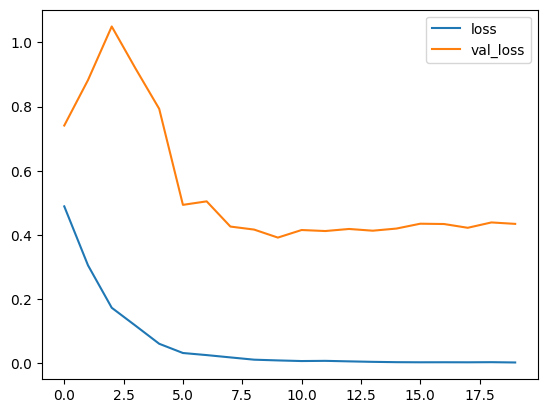

In [48]:
# Show the learning curves
import matplotlib
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

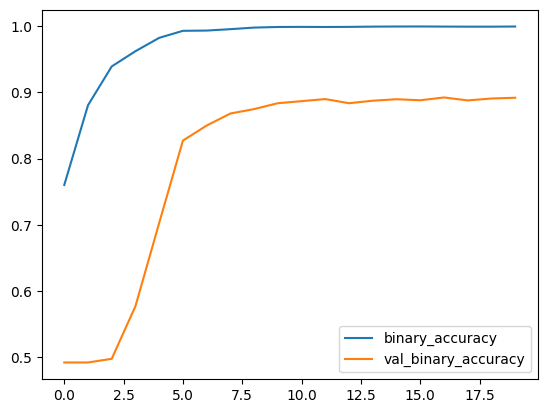

In [49]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>